## Returns

In [1]:
import pandas as pd

close = pd.DataFrame(
    {
        'ABC': [1, 5, 3, 6, 2],
        'EFG': [12, 51, 43, 56, 22],
        'XYZ': [35, 36, 36, 36, 37],},
    pd.date_range('10/01/2018', periods=5, freq='D'))
close

,ABC,EFG,XYZ
2018-10-01,1,12,35
2018-10-02,5,51,36
2018-10-03,3,43,36
2018-10-04,6,56,36
2018-10-05,2,22,37


In [2]:
import pandas as pd


def calculate_returns(close):
    """
    Compute returns for each ticker and date in close.
    
    Parameters
    ----------
    close : DataFrame
        Close prices for each ticker and date
    
    Returns
    -------
    returns : DataFrame
        Returns for each ticker and date
    """
    ret = (close - close.shift(1))/close.shift(1)
    
    return ret 

calculate_returns(close)



,ABC,EFG,XYZ
2018-10-01,NaN,NaN,NaN
2018-10-02,4.000000,3.250000,0.028571
2018-10-03,-0.400000,-0.156863,0.000000
2018-10-04,1.000000,0.302326,0.000000
2018-10-05,-0.666667,-0.607143,0.027778


## Pandas resample

In [3]:
import numpy as np
import pandas as pd

dates = pd.date_range('10/10/2018', periods=11, freq='D')
close_prices = np.arange(len(dates))

close = pd.Series(close_prices, dates)
close


2018-10-10     0
2018-10-11     1
2018-10-12     2
2018-10-13     3
2018-10-14     4
2018-10-15     5
2018-10-16     6
2018-10-17     7
2018-10-18     8
2018-10-19     9
2018-10-20    10
Freq: D, dtype: int64

In [4]:
# break the close into chucks of size 3
close.resample('3D')

close.resample('3D').first()


2018-10-10    0
2018-10-13    3
2018-10-16    6
2018-10-19    9
Freq: 3D, dtype: int64

In [5]:
close.iloc[::3]


2018-10-10    0
2018-10-13    3
2018-10-16    6
2018-10-19    9
Freq: 3D, dtype: int64

In [6]:
try:
    # Attempt resample on a series without a time index
    pd.Series(close_prices).resample('W')
except TypeError:
    print('It threw a TypeError.')
else:
    print('It worked.')

It threw a TypeError.


One of the resampling tasks it can help with is resampling on periods, like weeks. Let's resample close from it's days frequency to weeks. We'll use the "W" offset allies, which stands for Weeks.

In [7]:
pd.DataFrame({
    'days': close,
    'weeks': close.resample('W').first()})

,days,weeks
2018-10-10,0.0,NaN
2018-10-11,1.0,NaN
2018-10-12,2.0,NaN
2018-10-13,3.0,NaN
2018-10-14,4.0,0.0
2018-10-15,5.0,NaN
2018-10-16,6.0,NaN
2018-10-17,7.0,NaN
2018-10-18,8.0,NaN
2018-10-19,9.0,NaN


The weeks offset considers the start of a week on a Monday. Since 2018-10-10 is a Wednesday, the first group only looks at the first 5 items.

## OLHC


In [8]:
# get olhc from close resampled weekly
close.resample('W').ohlc()


,open,high,low,close
2018-10-14,0,4,0,4
2018-10-21,5,10,5,10


This is wrong as we resample already sampled data. 
We're getting the OHLC from close data. If we want OHLC data from already resampled data, we should resample the first price from the open data, resample the highest price from the high data, etc..

To get the weekly closing prices from close, you can use the Resampler.last function.


In [9]:


close.resample('W').last()


2018-10-14     4
2018-10-21    10
Freq: W-SUN, dtype: int64

In [10]:
def days_to_weeks(open_prices, high_prices, low_prices, close_prices):
    """Converts daily OHLC prices to weekly OHLC prices.
    
    Parameters
    ----------
    open_prices : DataFrame
        Daily open prices for each ticker and date
    high_prices : DataFrame
        Daily high prices for each ticker and date
    low_prices : DataFrame
        Daily low prices for each ticker and date
    close_prices : DataFrame
        Daily close prices for each ticker and date

    Returns
    -------
    open_prices_weekly : DataFrame
        Weekly open prices for each ticker and date
    high_prices_weekly : DataFrame
        Weekly high prices for each ticker and date
    low_prices_weekly : DataFrame
        Weekly low prices for each ticker and date
    close_prices_weekly : DataFrame
        Weekly close prices for each ticker and date
    """
    # open prices weekly
    open_prices_weekly = open_prices.resample('W').first()
    # close prices weekly
    close_prices_weekly = close_prices.resample('W').last()
    # high prices weekly
    high_prices_weekly = high_prices.resample('W').max()
    # low prices weekly
    low_prices_weekly = low_prices.resample('W').min()
    
    return open_prices_weekly, high_prices_weekly, low_prices_weekly, close_prices_weekly


olhc = close.resample('D').ohlc()

open_prices = olhc.open
high_prices = olhc.high
low_prices = olhc.low
close_prices = olhc.close


days_to_weeks(open_prices, high_prices, low_prices, close_prices)

(2018-10-14    0
 2018-10-21    5
 Freq: W-SUN, Name: open, dtype: int64,
 2018-10-14     4
 2018-10-21    10
 Freq: W-SUN, Name: high, dtype: int64,
 2018-10-14    0
 2018-10-21    5
 Freq: W-SUN, Name: low, dtype: int64,
 2018-10-14     4
 2018-10-21    10
 Freq: W-SUN, Name: close, dtype: int64)

## Momentum 

In [11]:
def generate_positions(prices):
    """
    Generate the following signals:
     - Long 30 share of stock when the price is above 50 dollars
     - Short 10 shares when it's below 20 dollars
    
    Parameters
    ----------
    prices : DataFrame
        Prices for each ticker and date
    
    Returns
    -------
    final_positions : DataFrame
        Final positions for each ticker and date
    """

    # convert the signal to int
    signal_long = (prices > 50)
    # convert the signal to int
    signal_long = signal_long.astype(np.int64)
    
    signal_short = (prices < 20)
    signal_short = signal_short.astype(np.int64)
    
    pos_long = 30 * signal_long
    pos_short = -10 * signal_short
    
    return pos_long + pos_short
# generate prices for a stock which goes between 0 and 100
prices = pd.DataFrame(
    {
        'ABC': np.random.randint(0, 100, 10),
        'EFG': np.random.randint(0, 100, 10),
        'XYZ': np.random.randint(0, 100, 10)
        },
    pd.date_range('10/01/2018', periods=10, freq='D'))

positions = generate_positions(prices)

# rename tickers in positions to append pos_ and add positions to prices

positions.columns = [f'pos_{c}' for c in positions.columns]

prices = pd.concat([prices, positions], axis=1)

prices

,ABC,EFG,XYZ,pos_ABC,pos_EFG,pos_XYZ
2018-10-01,8,79,47,-10,30,0
2018-10-02,53,87,65,30,30,30
2018-10-03,24,42,58,0,0,30
2018-10-04,61,68,95,30,30,30
2018-10-05,51,59,1,30,30,-10
2018-10-06,12,87,55,-10,30,30
2018-10-07,70,99,21,30,30,0
2018-10-08,34,0,59,0,-10,30
2018-10-09,87,63,92,30,30,30
2018-10-10,74,43,3,30,0,-10


## Get top and bottom performers in a month

In [12]:
import pandas as pd

month = pd.to_datetime('02/01/2018')
close_month = pd.DataFrame(
    {
        'A': 1,
        'B': 12,
        'C': 35,
        'D': 3,
        'E': 79,
        'F': 2,
        'G': 15,
        'H': 59},
    [month])

close_month

,A,B,C,D,E,F,G,H
2018-02-01,1,12,35,3,79,2,15,59


In [13]:
print(close_month.loc[month].nlargest(2))

print(close_month.loc[month].nsmallest(2))


E    79
H    59
Name: 2018-02-01 00:00:00, dtype: int64
A    1
F    2
Name: 2018-02-01 00:00:00, dtype: int64


In [14]:
# generate random prices and sectors for 10 companies
# for each month in 2018
import numpy as np
close_month = pd.DataFrame(
    {
        'A': np.random.randint(0, 100, 10),
        'B': np.random.randint(0, 100, 10),
        'C': np.random.randint(0, 100, 10),
        'D': np.random.randint(0, 100, 10),
        'E': np.random.randint(0, 100, 10),
        'F': np.random.randint(0, 100, 10),
        'G': np.random.randint(0, 100, 10),
        'H': np.random.randint(0, 100, 10),
        'I': np.random.randint(0, 100, 10)},
        pd.date_range('10/01/2018', periods=10, freq='ME')
    )

# assign a sector to each ticker with repeating values

sectors = {'A':'Tech', 'B':'Real Estate', 'C':'Tech', 'D':'Health', 'E':'Tech', 'F':'Real Estate', 'G':'Real Estate', 'H':'Health','I':'Health'}

close_month

,A,B,C,D,E,F,G,H,I
2018-10-31,24,43,40,15,42,82,92,3,89
2018-11-30,31,76,1,80,20,63,38,34,99
2018-12-31,39,27,2,2,52,30,51,30,64
2019-01-31,40,61,15,73,17,21,79,43,30
2019-02-28,17,12,84,87,51,52,60,41,63
2019-03-31,63,46,21,88,59,2,33,64,68
2019-04-30,22,71,43,86,14,27,4,34,32
2019-05-31,28,25,58,97,59,72,34,92,92
2019-06-30,59,53,78,49,20,75,3,31,97
2019-07-31,72,49,65,20,20,51,79,87,67


In [15]:
# function to get top industries for a given date and sector

def date_top_industries(prices, sectors, date, top_n):
    """
    Get the set of the top industries for the date
    
    Parameters
    ----------
    prices : DataFrame
        Prices for each ticker and date
    sector : Series
        Sector name for each ticker
    date : Date
        Date to get the top performers
    top_n : int
        Number of top performers to get
    
    Returns
    -------
    top_industries : set
        Top industries for the date
    """
    # get top tickers for the date
    top_tickers = prices.loc[date].nlargest(top_n)
    # print(top_tickers.index.values)
    # get top industries for the top tickers
    top_industries = set(sectors[x] for x in top_tickers.index.values)    
    return top_industries

date_top_industries(close_month, sectors, pd.to_datetime('12/31/2018'), 2)

{'Health', 'Tech'}

In [16]:
# function to get top industries for a given date and sector

def date_bottom_industries(prices, sectors, date, bottom_n):
    """
    Get the set of the top industries for the date
    
    Parameters
    ----------
    prices : DataFrame
        Prices for each ticker and date
    sector : Series
        Sector name for each ticker
    date : Date
        Date to get the top performers
    top_n : int
        Number of top performers to get
    
    Returns
    -------
    top_industries : set
        Top industries for the date
    """
    # get top tickers for the date
    bottom_tickers = prices.loc[date].nsmallest(bottom_n)
    print(bottom_tickers.index.values)
    # get top industries for the top tickers
    bottom_industries = set(sectors[x] for x in bottom_tickers.index.values)    
    return bottom_industries

date_bottom_industries(close_month, sectors, pd.to_datetime('12/31/2018'), 2)

['C' 'D']


{'Health', 'Tech'}

## Get data frme FRM

In [17]:
from urllib.request import urlopen

import certifi
import json
import ssl
from urllib.request import urlopen
from config import FRM_API

# Create a custom SSL context
context = ssl.create_default_context(cafile=certifi.where())


def get_jsonparsed_data(ticker,start_date,end_date):
    url = (f"https://financialmodelingprep.com/api/v3/historical-market-capitalization/{ticker}?limit=650&from={start_date}&to={end_date}&apikey={FRM_API}")
    # Create a custom SSL context
    context = ssl.create_default_context(cafile=certifi.where())

    response = urlopen(url, context=context)
    data = response.read().decode("utf-8")
    jdata = json.loads(data)
    # convert json to dataframe
    df = pd.DataFrame(jdata)

    mcap = df['marketCap'].values[0]
    return mcap







## Normality

In [7]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
# import quiz_tests

# Set plotting options
%matplotlib inline
plt.rc('figure')


In [8]:
# Sample A: Normal distribution
sample_a = stats.norm.rvs(loc=0.0, scale=1.0, size=(1000,))

# Sample B: Non-normal distribution
sample_b = stats.lognorm.rvs(s=0.5, loc=0.0, scale=1.0, size=(1000,))


### Boxplot-Whisker Plot and Histogram

One can visually check if a distribution looks normally distributed. I will use a box whisker plot to check the symmetry around the mean. A histogram lets us see the overall shape.  I will also use a QQ-plot to compare the data distribution with a normal distribution.


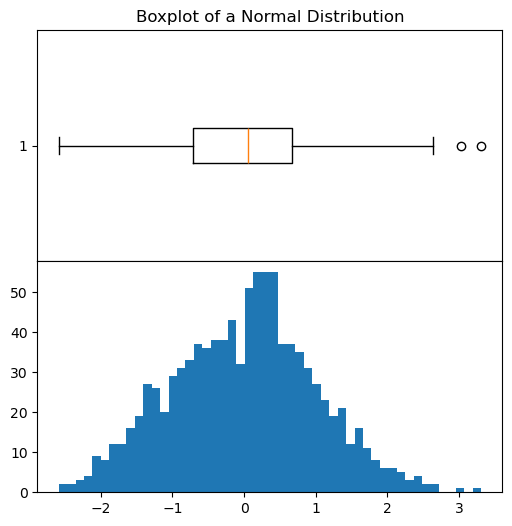

In [15]:
# Sample A: Normal distribution
sample_a = stats.norm.rvs(loc=0.0, scale=1.0, size=(1000,))
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
axes[0].boxplot(sample_a, vert=False)
axes[1].hist(sample_a, bins=50)
axes[0].set_title("Boxplot of a Normal Distribution")
fig.subplots_adjust(hspace=0.0)

This is nornal with symmtery and the range of the edges of box plot with very few points as outliers.

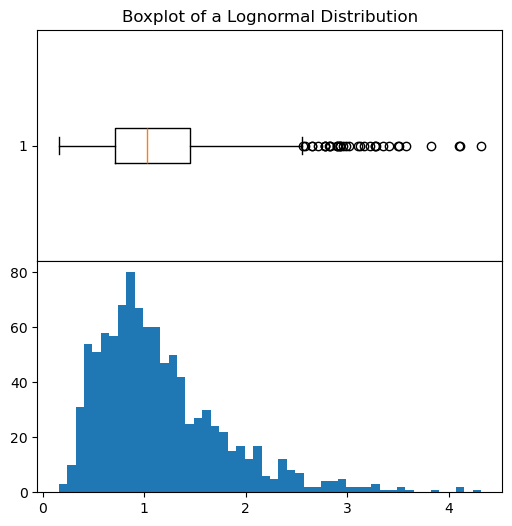

In [14]:
# Sample B: Non-normal distribution
sample_b = stats.lognorm.rvs(s=0.5, loc=0.0, scale=1.0, size=(1000,))
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
axes[0].boxplot(sample_b, vert=False)
axes[1].hist(sample_b, bins=50)
axes[0].set_title("Boxplot of a Lognormal Distribution")
fig.subplots_adjust(hspace=0.0)

This is not normal. The boxplot is not symmetric. This is right skewed with a lot of points as outliers on the right side of median.

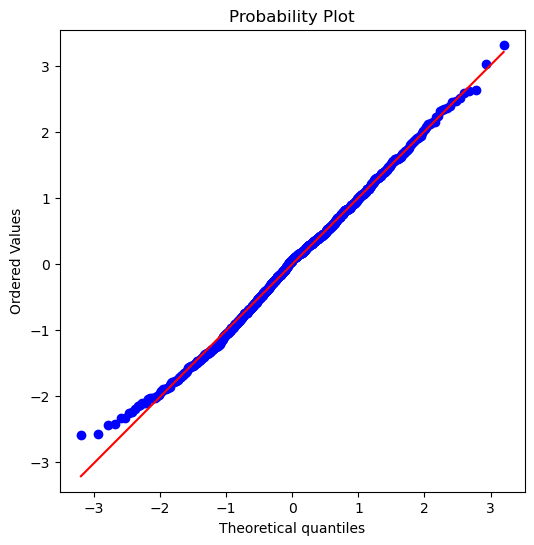

In [17]:
# Q-Q plot of normally-distributed sample
plt.figure(figsize=(6, 6)); plt.axis('equal')
stats.probplot(sample_a, dist='norm', plot=plt);

QQ plots shows that most of the points are on the straight line with median of the sample same as the theoretical quantiles (0,0) point. Therefore the distribution is normal

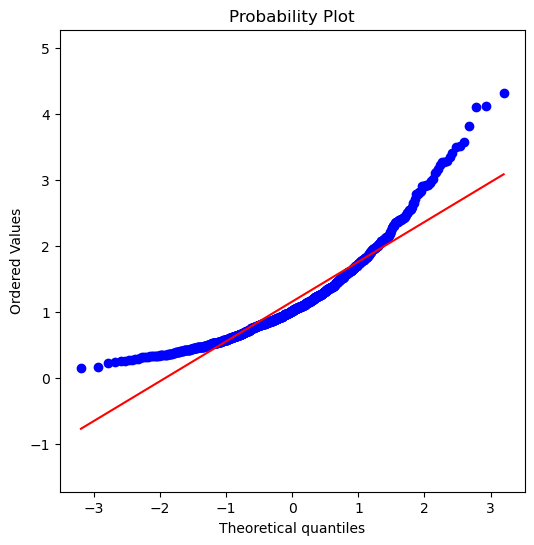

In [18]:

# Q-Q plot of non-normally-distributed sample
plt.figure(figsize=(6, 6)); plt.axis('equal')
stats.probplot(sample_b, dist='norm', plot=plt);

This is clearly not a normal distribution as the points curve and most of the points don't lie on the straight line.

## Testing for Normality

### Shapiro-Wilk

The Shapiro-Wilk test is available in the scipy library. It tests the null hypothesis that the data was drawn from a normal distribution. The test returns two values: the test statistic, and the p-value. p-value is the probability of observing a test statistic as extreme or more extreme as the one observed, assuming the null hypothesis is true. p-value greater than 0.05 means that the null hypothesis cannot be rejected.

In [21]:
def is_normal(sample, test=stats.shapiro, p_level=0.05):
    """Apply a normality test to check if sample is normally distributed."""
    t_stat, p_value = test(sample)
    print(f"Test statistic: {t_stat}, p-value: {p_value}")
    if p_value < p_level:
        print("Reject the null hypothesis that the sample comes from a normal distribution.")
    else:
        print("Fail to reject the null hypothesis that the sample comes from a normal distribution.")
    # print("Is the distribution Likely Normal? {}".format(p_value > p_level))
# Using Shapiro-Wilk test (default)
print("Sample A:-"); is_normal(sample_a);
print("Sample B:-"); is_normal(sample_b);

Sample A:-
Test statistic: 0.9970897147478172, p-value: 0.06629680207795809
Fail to reject the null hypothesis that the sample comes from a normal distribution.
Sample B:-
Test statistic: 0.9001189287364875, p-value: 5.341053393345327e-25
Reject the null hypothesis that the sample comes from a normal distribution.


### Kolmogorov-Smirnov Test

The K-S test compares two distributions. Two test normality, one of the distribution is chosen as a normal distribution.. The test statistic is the maximum absolute difference between the empirical cumulative distribution function (CDF) of the sample and the CDF of the standard normal distribution. If p-value is less than a threshold, the null hypothesis: the sample comes from a normal distribution is rejected. 

In [25]:
def is_normal(sample, test=stats.kstest, p_level=0.05):
    """Apply a normality test to check if sample is normally distributed."""
    # get the arguments for the normal test with mean and standard deviation
    normal_args = (np.mean(sample), np.std(sample))

    # apply the test
    t_stat, p_value = test(sample, 'norm', normal_args)
    
    print(f"Test statistic: {t_stat}, p-value: {p_value}")
    if p_value < p_level:
        print("Reject the null hypothesis that the sample comes from a normal distribution.")
    else:
        print("Fail to reject the null hypothesis that the sample comes from a normal distribution.")
    # print("Is the distribution Likely Normal? {}".format(p_value > p_level))
# Using Shapiro-Wilk test (default)
print("Sample A:-"); is_normal(sample_a);
print("Sample B:-"); is_normal(sample_b);


Sample A:-
Test statistic: 0.029053210662682627, p-value: 0.3604860305879991
Fail to reject the null hypothesis that the sample comes from a normal distribution.
Sample B:-
Test statistic: 0.10444775596651168, p-value: 5.942555825466609e-10
Reject the null hypothesis that the sample comes from a normal distribution.


## Regression with two stocks






In [28]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

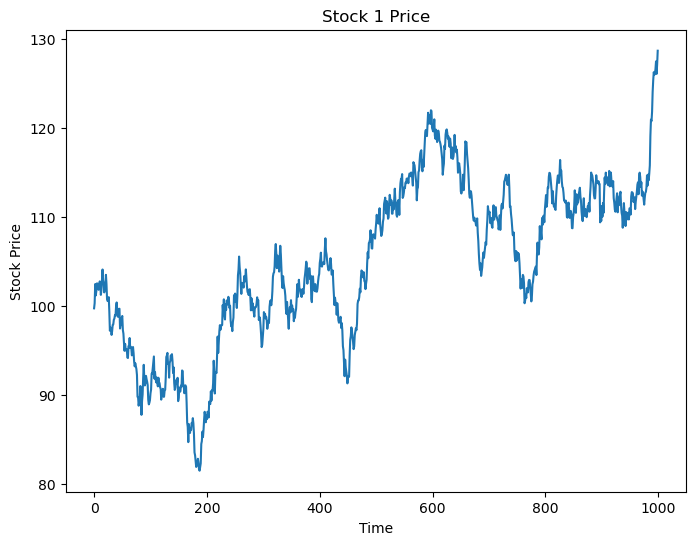

In [34]:
# create a stock price series

# just set the seed for the random number generator
np.random.seed(2018)
# set drift for the random walk
drift = 100
# returns
r1 = np.random.normal(0, 1, 1000) 
s1 = pd.Series(np.cumsum(r1), name='s1') + drift
s1.name = 's1'
s1.plot(figsize=(8,6), title='Stock 1 Price', ylabel='Stock Price', xlabel='Time')
plt.show()


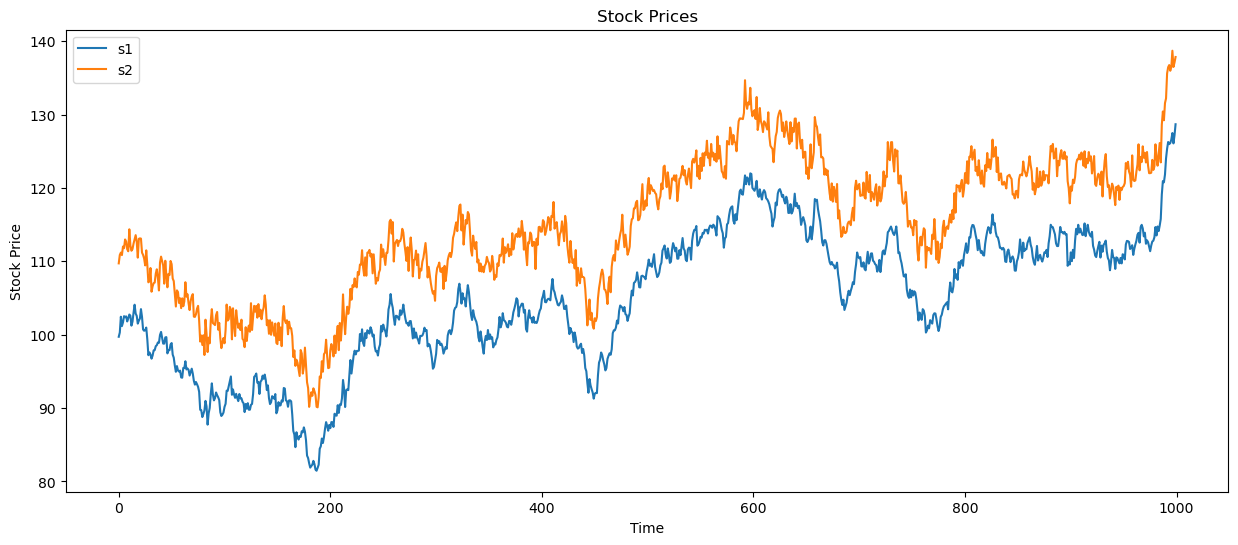

In [36]:
# set offset for the second stock price
offset = 10

# set noise
noise = np.random.normal(0, 1, 1000)

# create second price series
s2 = s1 + offset + noise
# name the series
s2.name = 's2'

# combine the two series
pd.concat([s1, s2], axis=1).plot(figsize=(15,6), title='Stock Prices', ylabel='Stock Price', xlabel='Time')
plt.show()


Now I have the two stocks time series and I will use it to perform linear regression analysis.

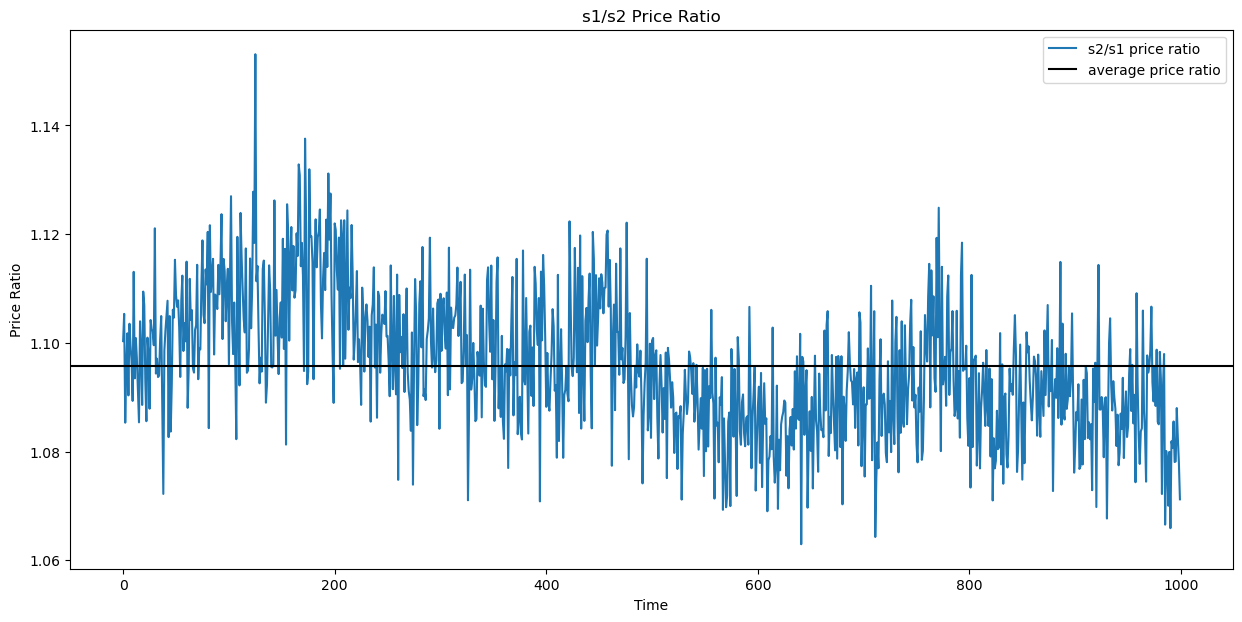

In [40]:
# get the ratio of prices 
price_ratio = s2/s1
# see how the ratio evolves with time.
price_ratio.plot(figsize=(15,7), title='s1/s2 Price Ratio', ylabel='Price Ratio', xlabel='Time') 
plt.axhline(price_ratio.mean(), color='black') 
plt.legend(['s2/s1 price ratio', 'average price ratio'])
plt.show()

In [41]:
print(f"average price ratio {price_ratio.mean():.4f}")

average price ratio 1.0958


### Calculate hedge ratio with regression

In [47]:
# linear regression model
lr = LinearRegression()
# fit the model with s1 as independent variable and s2 as dependent
lr.fit(s1.values.reshape(-1,1),s2.values.reshape(-1,1))

# get the hedge ratio
hedge_ratio = lr.coef_[0][0]
hedge_ratio

1.0042618236703096

In [48]:
intercept = lr.intercept_[0]
intercept

9.52221715308167